# Module 3

Pip install $\texttt{pyiqa}$ for FR and NR IQA measures

In [1]:
!pip install pyiqa

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 12.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.4/129.4 kB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.8/46.8 kB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.0/178.0 kB 12.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 261.3/261.3 kB 17.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 106.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 115.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 87.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 47.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

Import relevant modules

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import sys
sys.path.append('./drive/MyDrive/a7_coursework_colab')
from unet import Unet
import os
from glob import glob
import matplotlib.image as mpimg
from skimage.metrics import peak_signal_noise_ratio, structural_similarity
from pyiqa import create_metric  # Import pyiqa
import torch.nn.functional as F
import cv2

Load model like in module 2

In [3]:
device = torch.device('cpu')

model = Unet(3, 3, chans=64).to(device)
model.load_state_dict(torch.load('./drive/MyDrive/a7_coursework_colab/denoiser.pth', map_location=device))

<All keys matched successfully>

In [4]:
torch.manual_seed(42) # for reproducibility

Add previously given functions

In [5]:
def conjugate_gradient(A, b, x0, max_iter, tol):
  """
  CG for solving Ax=b.
  Here, the argument A is a function that returns Ax
  """
  x = x0
  r = b-A(x)
  d = r
  for _ in range(max_iter):

    z = A(d)
    rr = torch.sum(r**2)
    alpha = rr/torch.sum(d*z)
    x += alpha*d
    r -= alpha*z

    if torch.norm(r)/torch.norm(b) < tol:
      break

  beta = torch.sum(r**2)/rr
  d = r + beta*d
  return x

In [6]:
def conv2d_block(kernel, channels, p, device, stride=1):
  """
  Returns nn.Conv2d and nn.ConvTranspose2d modules from 2D kernel, such that
  nn.ConvTranspose2d is the adjoint operator of nn.Conv2d
  Arg:
  kernel: 2D kernel, p x p is the kernel size
  channels: number of image channels
  """
  kernel_size = kernel.shape
  kernel = kernel/kernel.sum()
  kernel = kernel.repeat(channels, 1, 1, 1)
  filter = nn.Conv2d(
    in_channels=channels, out_channels=channels,
    kernel_size=kernel_size, groups=channels, bias=False, stride=stride,
    padding=p//2
  )
  filter.weight.data = kernel
  filter.weight.requires_grad = False

  filter_adjoint = nn.ConvTranspose2d(
    in_channels=channels, out_channels=channels,
    kernel_size=kernel_size, groups=channels, bias=False, stride=stride,
    padding=p//2,
  )
  filter_adjoint.weight.data = kernel
  filter_adjoint.weight.requires_grad = False

  return filter.to(device), filter_adjoint.to(device)

Define deblurring PnP-ADMM function below like done before

In [7]:
def pnp_admm_deblur(y, kernel, D, p, device, eta=1e-4, max_iter=10, cg_max_iter=10, cg_tol=1e-5):
    """
    Plug-and-Play ADMM for image deblurring.

    Parameters:
    - y: blurry input image (shape [B, C, H, W])
    - kernel: 2D blur kernel (shape [p, p])
    - D: denoiser model (e.g. pretrained U-Net)
    - p: size of blur kernel
    - device: torch device
    - eta: ADMM regularisation parameter
    - max_iter: ADMM outer iterations
    - cg_max_iter: conjugate gradient iterations
    - cg_tol: tolerance for CG
    """
    B, C, H, W = y.shape

    A_op, At_op = conv2d_block(kernel, channels=C, p=p, device=device) # get forward and adjoint blur operators

    # Define operator functions
    def A(z): return A_op(z)
    def At(z): return At_op(z)

    def CG_operator(z): # CG system matrix: (AtA + eta * I)
        return At(A(z)) + eta * z

    # Initialise variables
    x = torch.zeros_like(y)
    v = torch.zeros_like(y)
    u = torch.zeros_like(y)

    for _ in range(max_iter):
        d = At(y) + eta * (v - u)
        x = conjugate_gradient(CG_operator, d, x, cg_max_iter, cg_tol)
        v = D(x + u)
        u = u + (x - v)

    x = torch.clamp(x, 0.0, 1.0) # Clip output to [0, 1]

    return x

Define inpainting PnP-ADMM function like before

In [ ]:
def pnp_admm_inpaint(y, A, At, D, eta=1e-4, max_iter=20, cg_max_iter=10, cg_tol=1e-5):
    """
    Performs Plug-and-Play (PnP) ADMM-based image inpainting.

    Parameters:
        y (torch.Tensor): Observed degraded image tensor.
        A (function): Forward operator (e.g., masking or degradation function).
        At (function): Adjoint of the forward operator A.
        D (function): Denoiser function used as a plug-in regulariser (e.g., a deep network).
        eta (float): ADMM penalty parameter controlling balance between fidelity and prior.
        max_iter (int): Number of ADMM iterations.
        cg_max_iter (int): Maximum iterations for the inner Conjugate Gradient (CG) solver.
        cg_tol (float): Tolerance for CG convergence.

    Returns:
        torch.Tensor: Inpainted image tensor, clamped to the range [0, 1].
    """
    def CG_operator(z):
        return At(A(z)) + eta * z

    x = torch.zeros_like(y)
    v = torch.zeros_like(y)
    u = torch.zeros_like(y)

    for _ in range(max_iter):
        d = At(y) + eta * (v - u)
        x = conjugate_gradient(CG_operator, d, x, cg_max_iter, cg_tol)
        v = D(x + u)
        u = u + (x - v)

    return torch.clamp(x, 0, 1)

### Exercise 3.1

3.1.a

Need to evaluate the deblurring and inpainting results with PnP-ADMM and use PSNR and SSIM IQA measures to evaluate performance

In [ ]:
# Image loader
def load_image_as_tensor(path):
    """
    Loads an image from disk and converts it to a PyTorch tensor suitable for model input.

    Parameters:
        path (str): File path to the image.

    Returns:
        torch.Tensor: A 4D tensor of shape [1, C, H, W] with float values normalised to [0, 1],
                      and moved to the appropriate device.
    """
    img_np = mpimg.imread(path)
    if img_np.dtype == np.uint8:
        img_np = img_np.astype(np.float32) / 255.0 # normalise input to [0,1] as before
    img_tensor = torch.from_numpy(img_np).permute(2, 0, 1).unsqueeze(0)
    return img_tensor.to(device)

In [10]:
# Parameters
image_dir = './drive/MyDrive/a7_coursework_colab/data'
p = 13
eta = 1e-4
max_iter = 10
cg_max_iter = 10

model.eval()

image_paths = sorted(glob(os.path.join(image_dir, '*.jpg')))
img = load_image_as_tensor(image_paths[0])  # load only the first image

kernel = torch.ones((p, p), device=device) / (p * p) # blur kernel
A_op, _ = conv2d_block(kernel, channels=3, p=p, device=device) # forward operator

# For inpainting
_, _, h, w = img.shape
channels = 3 # colour images
mask = torch.rand(1,channels,h,w).to(device) # 3 channels and has hxw pixels
mask = mask < 0.4 # this means that approx. 40% pixels will be retained
def forward(x): # ensure that the image is of size 1x3xhxw
  return x*mask # element-wise multiplication with the image
adjoint = forward

with torch.no_grad():
    y_blur = A_op(img)
    x_hat_deblur = pnp_admm_deblur(y_blur, kernel, model, p, device, eta=eta, max_iter=max_iter, cg_max_iter=cg_max_iter) # deblur it using PnP-ADMM to get reconstruction

    y_inpaint = forward(img)
    x_hat_inpaint = pnp_admm_inpaint(y_inpaint, forward, adjoint, model, eta=eta, max_iter=max_iter, cg_max_iter=cg_max_iter) # inpaint it using PnP-ADMM to get reconstruction

    # Convert to numpy
    img_np = img.squeeze(0).permute(1, 2, 0).cpu().numpy()
    deblur_np = x_hat_deblur.squeeze(0).permute(1, 2, 0).cpu().numpy()
    inpaint_np = x_hat_inpaint.squeeze(0).permute(1, 2, 0).cpu().numpy()

    img_np = np.clip(img_np, 0, 1)
    deblur_np = np.clip(deblur_np, 0, 1)
    inpaint_np = np.clip(inpaint_np, 0, 1)

    # PSNR and SSIM metrics
    psnr_deblur = peak_signal_noise_ratio(img_np, deblur_np, data_range=1.0)
    ssim_deblur = structural_similarity(img_np, deblur_np, data_range=1.0, channel_axis=2)

    psnr_inpaint = peak_signal_noise_ratio(img_np, inpaint_np, data_range=1.0)
    ssim_inpaint = structural_similarity(img_np, inpaint_np, data_range=1.0, channel_axis=2)

    # Print metrics
    print(" Evaluation on First Image")
    print(f"Deblurring - PSNR: {psnr_deblur:.2f}, SSIM: {ssim_deblur:.4f}")
    print(f"Inpainting - PSNR: {psnr_inpaint:.2f}, SSIM: {ssim_inpaint:.4f}")

 Evaluation on First Image
Deblurring - PSNR: 19.82, SSIM: 0.6325
Inpainting - PSNR: 7.61, SSIM: 0.1820


Now do the same using the No Reference NIQE and Full Reference LPIPS IQAs

In [11]:
# Parameters
image_dir = './drive/MyDrive/a7_coursework_colab/data'
p = 13
eta = 1e-4
max_iter = 10
cg_max_iter = 10
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model.eval()

image_paths = sorted(glob(os.path.join(image_dir, '*.jpg')))
img = load_image_as_tensor(image_paths[0])  # load only the first image

kernel = torch.ones((p, p), device=device) / (p * p) # blur kernel
A_op, _ = conv2d_block(kernel, channels=3, p=p, device=device)

#  Inpainting mask
_, _, h, w = img.shape
channels = 3  # for colour images
mask = torch.rand(1, channels, h, w).to(device)  # 3 channels and has hxw pixels
mask = mask < 0.4  # approx. 40% pixels will be retained

def forward(x):  # ensure image is 1x3xhxw
    return x * mask  # element-wise multiplication

adjoint = forward

# Initialise IQA metrics from pyiqa
niqe_metric = create_metric('niqe').to(device)  # Blind metric
lpips_metric = create_metric('lpips', net='alex').to(device)  # Reference-based metric

with torch.no_grad():
    y_blur = A_op(img)
    x_hat_deblur = pnp_admm_deblur(y_blur, kernel, model, p, device, eta=eta, max_iter=max_iter, cg_max_iter=cg_max_iter)

    y_inpaint = forward(img)
    x_hat_inpaint = pnp_admm_inpaint(y_inpaint, forward, adjoint, model, eta=eta, max_iter=max_iter, cg_max_iter=cg_max_iter)

    # Clamp results to valid range [0,1]
    img_clamped = img.clamp(0, 1)
    deblur_clamped = x_hat_deblur.clamp(0, 1)
    inpaint_clamped = x_hat_inpaint.clamp(0, 1)

    # Compute NIQE (no reference) on outputs (for comparison, also compute on original)
    niqe_deblur = niqe_metric(deblur_clamped).item()
    niqe_inpaint = niqe_metric(inpaint_clamped).item()
    niqe_orig = niqe_metric(img_clamped).item()

    # Compute LPIPS (full reference) between original and reconstructed images
    lpips_deblur = lpips_metric(deblur_clamped, img_clamped).item()
    lpips_inpaint = lpips_metric(inpaint_clamped, img_clamped).item()

    # Print results
    print("Evaluation on First Image using NIQE and LPIPS")
    print(f"Original image NIQE: {niqe_orig:.4f}")
    print(f"Deblurring - NIQE: {niqe_deblur:.4f}, LPIPS: {lpips_deblur:.4f}")
    print(f"Inpainting - NIQE: {niqe_inpaint:.4f}, LPIPS: {lpips_inpaint:.4f}")

Downloading: "https://huggingface.co/chaofengc/IQA-PyTorch-Weights/resolve/main/niqe_modelparameters.mat" to /root/.cache/torch/hub/pyiqa/niqe_modelparameters.mat



100%|██████████| 8.15k/8.15k [00:00<00:00, 11.6MB/s]
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:00<00:00, 271MB/s]


Downloading: "https://huggingface.co/chaofengc/IQA-PyTorch-Weights/resolve/main/LPIPS_v0.1_alex-df73285e.pth" to /root/.cache/torch/hub/pyiqa/LPIPS_v0.1_alex-df73285e.pth



100%|██████████| 5.87k/5.87k [00:00<00:00, 8.26MB/s]


Loading pretrained model LPIPS from /root/.cache/torch/hub/pyiqa/LPIPS_v0.1_alex-df73285e.pth
Evaluation on First Image using NIQE and LPIPS
Original image NIQE: 6.7596
Deblurring - NIQE: 7.9261, LPIPS: 0.3971
Inpainting - NIQE: 21.9469, LPIPS: 1.0825


3.1.b

Create one degraded image using deblurring and another using random pixel dropout and fine tune parameters such that they have the same PSNR

In [12]:
image_path = './drive/MyDrive/a7_coursework_colab/data/Image_1057.jpg'  # set image path
p = 13  # blur kernel size
mask_keep_ratio_psnr = 0.901  # manually set dropout keep ratio

original = load_image_as_tensor(image_path)
_, C, H, W = original.shape

In [ ]:
def apply_mask(x, keep_ratio):
    """
    Applies a random binary mask to an image tensor to simulate missing data.

    Parameters:
        x (torch.Tensor): Input image tensor of shape [1, C, H, W].
        keep_ratio (float): Fraction of pixels to keep (between 0 and 1).

    Returns:
        torch.Tensor: Masked image tensor where only a subset of pixels are retained.
    """
    mask = (torch.rand(1, C, H, W, device=device) < keep_ratio).float()
    return x * mask

def compute_psnr(img1, img2):
    """
    Computes the Peak Signal-to-Noise Ratio (PSNR) between two image tensors.

    Parameters:
        img1 (torch.Tensor): First image tensor of shape [1, C, H, W], with values in [0, 1].
        img2 (torch.Tensor): Second image tensor of the same shape as `img1`.
    
    Returns:
        float: PSNR value in decibels (dB), higher means better quality.
    """
    img1_np = img1.squeeze().permute(1, 2, 0).cpu().numpy()
    img2_np = img2.squeeze().permute(1, 2, 0).cpu().numpy()
    return peak_signal_noise_ratio(img1_np, img2_np, data_range=1.0)

In [21]:
A_op, _ = conv2d_block(kernel, channels=3, p=p, device=device)
psnr_blurred = A_op(original) # apply blur
psnr_masked = apply_mask(original, mask_keep_ratio_psnr) # Apply pixel dropout

# Compute PSNRs
psnr_blur = compute_psnr(original, psnr_blurred)
psnr_mask = compute_psnr(original, psnr_masked)

print(f"PSNR (Blurred): {psnr_blur:.2f} dB")
print(f"PSNR (Masked): {psnr_mask:.2f} dB")

PSNR (Blurred): 15.08 dB
PSNR (Masked): 15.08 dB


Create one degraded image using deblurring and another using random pixel dropout and fine tune parameters such that they have the same SSIM

In [ ]:
def compute_ssim(img1, img2):
    """
    Computes the Structural Similarity Index (SSIM) between two image tensors.

    Parameters:
        img1 (torch.Tensor): First image tensor of shape [1, C, H, W], with values in [0, 1].
        img2 (torch.Tensor): Second image tensor of the same shape as `img1`.

    Returns:
        float: SSIM value between the two images, ranging from -1 to 1 (higher is more similar).
    """
    img1_np = img1.squeeze().permute(1, 2, 0).cpu().numpy()
    img2_np = img2.squeeze().permute(1, 2, 0).cpu().numpy()
    return structural_similarity(img1_np, img2_np, data_range=1.0, channel_axis=2)

In [61]:
image_path = './drive/MyDrive/a7_coursework_colab/data/Image_1057.jpg'  # set image path
p = 13  # blur kernel size
mask_keep_ratio_ssim = 0.5604  # manually set dropout keep ratio
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

original = load_image_as_tensor(image_path)
_, C, H, W = original.shape

A_op, _ = conv2d_block(kernel, channels=3, p=p, device=device)
ssim_blurred = A_op(original) # apply blur
ssim_masked = apply_mask(original, mask_keep_ratio_ssim) # Apply pixel dropout

# Compute SSIMs
ssim_blur = compute_ssim(original, ssim_blurred)
ssim_mask = compute_ssim(original, ssim_masked)

print(f"SSIM (Blurred): {ssim_blur:.4f}")
print(f"SSIM (Masked): {ssim_mask:.4f}")

SSIM (Blurred): 0.2637
SSIM (Masked): 0.2637


Now let's remove the background pixels using OpenCV's grabcut algorithm and see what happens to the PSNR and SSIM values

In [ ]:
def load_image_grabcut(path):
    """
    Loads an image from disk, segments the foreground using GrabCut,
    and returns the foreground as a normalised PyTorch tensor.

    Parameters:
        path (str): File path to the input image.

    Returns:
        torch.Tensor: Tensor of shape [1, 3, H, W] containing the segmented
                      foreground image, normalised to [0, 1] and moved to `device`.
    """
    img = cv2.imread(path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    mask = np.zeros(img_rgb.shape[:2], np.uint8)

    # Define a rectangle covering the foreground object roughly
    h, w = img_rgb.shape[:2]
    rect = (10, 10, w - 20, h - 20)

    bgdModel = np.zeros((1, 65), np.float64)
    fgdModel = np.zeros((1, 65), np.float64)

    # Run GrabCut
    cv2.grabCut(img_rgb, mask, rect, bgdModel, fgdModel, 5, cv2.GC_INIT_WITH_RECT)

    # Create binary mask
    mask2 = np.where((mask == 2) | (mask == 0), 0, 1).astype('uint8')
    img_rgb = img_rgb * mask2[:, :, np.newaxis]

    # Convert to float32 and normalise
    img_rgb = img_rgb.astype(np.float32) / 255.0

    # Convert to PyTorch tensor
    img_tensor = torch.from_numpy(img_rgb).permute(2, 0, 1).unsqueeze(0)
    return img_tensor.to(device)

In [63]:
original_no_bkg = load_image_grabcut(image_path)
_, C, H, W = original.shape

A_op, _ = conv2d_block(kernel, channels=3, p=p, device=device)
psnr_blurred_no_bkg = A_op(original_no_bkg) # apply blur
psnr_masked_no_bkg = apply_mask(original_no_bkg, mask_keep_ratio_psnr)

A_op, _ = conv2d_block(kernel, channels=3, p=p, device=device)
ssim_blurred_no_bkg = A_op(original_no_bkg) # apply blur
ssim_masked_no_bkg = apply_mask(original_no_bkg, mask_keep_ratio_ssim)

psnr_blur_no_bkg = compute_psnr(original_no_bkg, psnr_blurred_no_bkg)
psnr_mask_no_bkg = compute_psnr(original_no_bkg, psnr_masked_no_bkg)

ssim_blur_no_bkg = compute_ssim(original_no_bkg, ssim_blurred_no_bkg)
ssim_mask_no_bkg = compute_ssim(original_no_bkg, ssim_masked_no_bkg)

print("Evaluation After GrabCut Background Removal")
print(f"PSNR (Blurred): {psnr_blur_no_bkg:.2f} dB")
print(f"PSNR (Masked): {psnr_mask_no_bkg:.2f} dB")
print(f"SSIM (Blurred): {ssim_blur_no_bkg:.4f}")
print(f"SSIM (Masked): {ssim_mask_no_bkg:.4f}")

Evaluation After GrabCut Background Removal
PSNR (Blurred): 18.28 dB
PSNR (Masked): 20.47 dB
SSIM (Blurred): 0.5218
SSIM (Masked): 0.6855


Let's plot these images for visualisation

In [ ]:
def to_numpy_img(tensor):
    """
    Converts a PyTorch tensor image to a NumPy array suitable for visualisation.

    Parameters:
        tensor (torch.Tensor): Image tensor of shape [1, C, H, W] or [C, H, W].

    Returns:
        numpy.ndarray: Image as a NumPy array of shape [H, W, C], with values clipped to [0, 1].
    """
    return tensor.squeeze().permute(1, 2, 0).cpu().numpy().clip(0, 1)

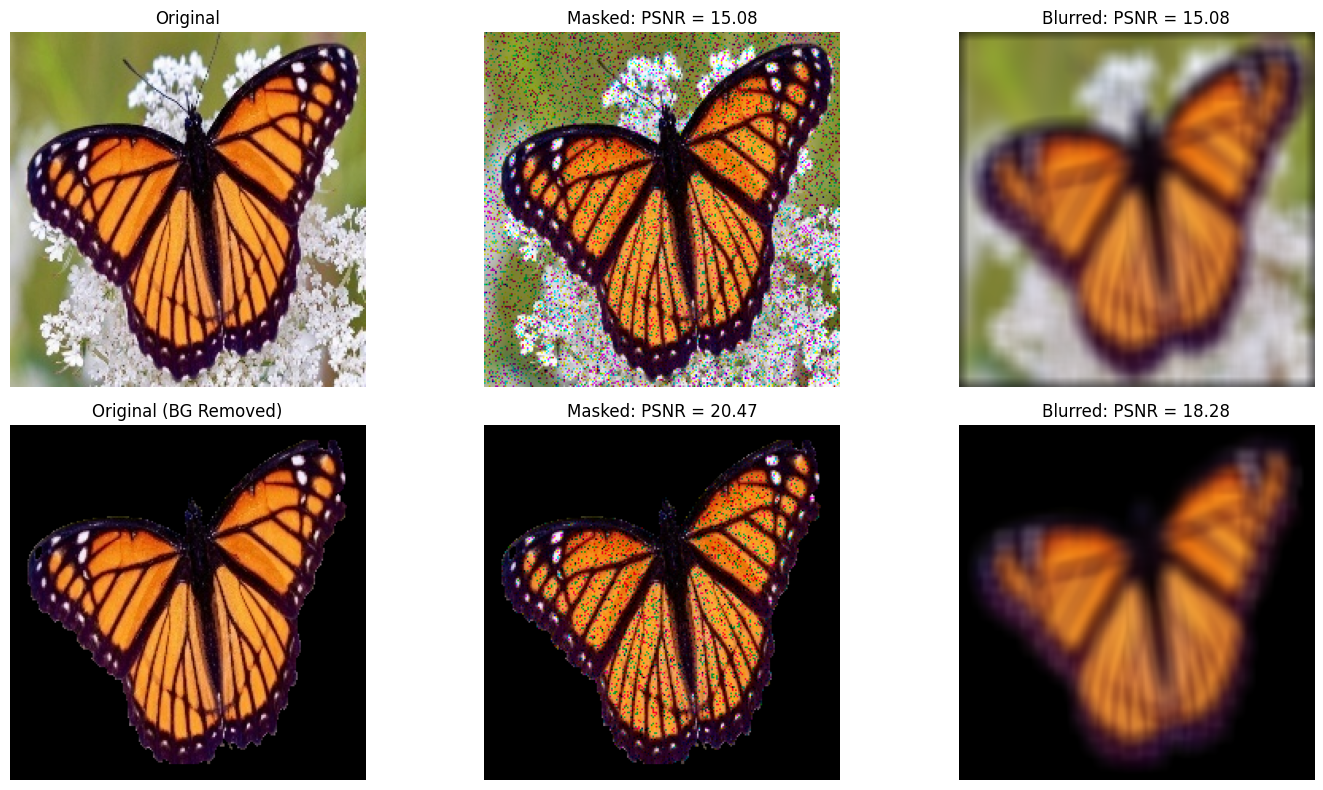

In [65]:
imgs = [
    to_numpy_img(original),
    to_numpy_img(psnr_masked),
    to_numpy_img(psnr_blurred),
    to_numpy_img(original_no_bkg),
    to_numpy_img(psnr_masked_no_bkg),
    to_numpy_img(psnr_blurred_no_bkg)
]

titles = [
    "Original", f"Masked: PSNR = {psnr_mask:.2f}", f"Blurred: PSNR = {psnr_blur:.2f}",
    "Original (BG Removed)", f"Masked: PSNR = {psnr_mask_no_bkg:.2f}", f"Blurred: PSNR = {psnr_blur_no_bkg:.2f}"
]

fig, axs = plt.subplots(2, 3, figsize=(15, 8))

for i, ax in enumerate(axs.flat):
    ax.imshow(imgs[i])
    ax.set_title(titles[i])
    ax.axis('off')

plt.tight_layout()
plt.show()

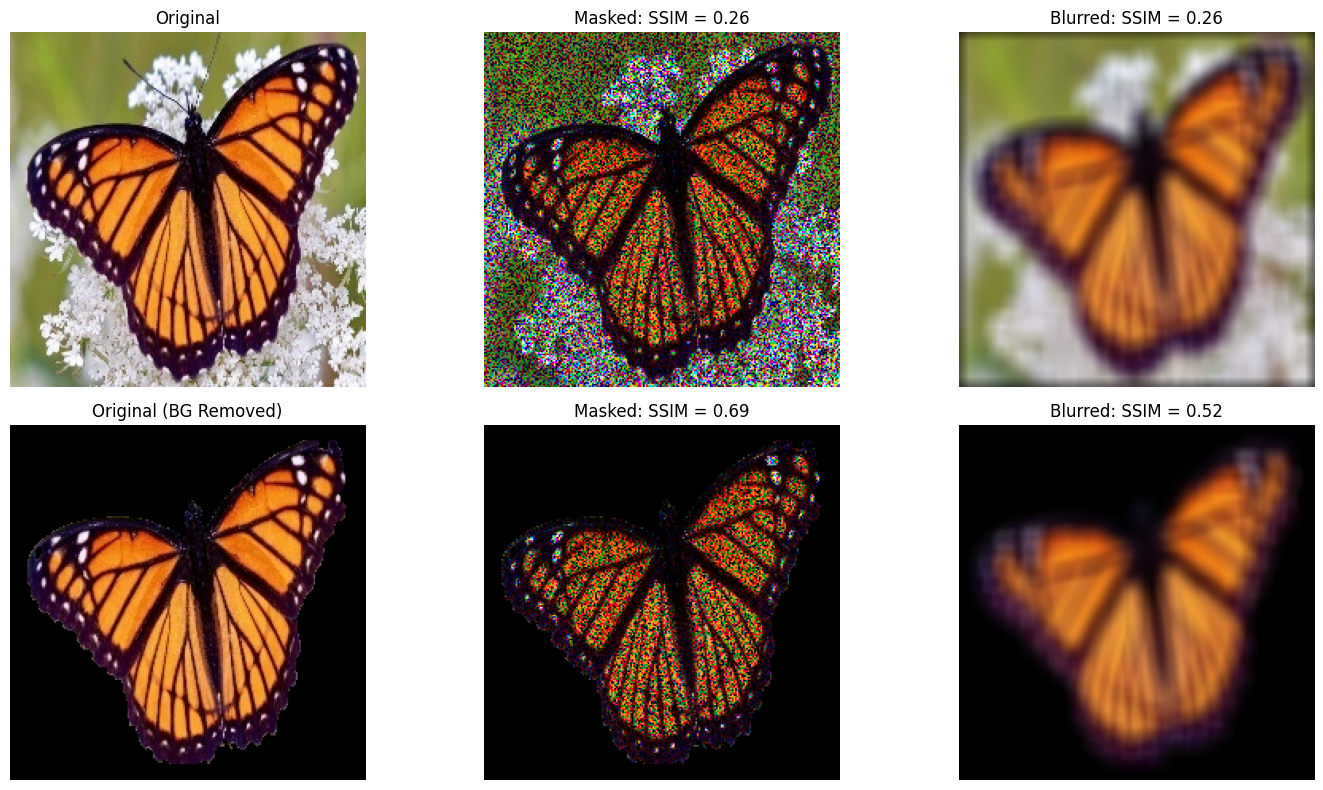

In [66]:
imgs = [
    to_numpy_img(original),
    to_numpy_img(ssim_masked),
    to_numpy_img(ssim_blurred),
    to_numpy_img(original_no_bkg),
    to_numpy_img(ssim_masked_no_bkg),
    to_numpy_img(ssim_blurred_no_bkg)
]

titles = [
    "Original", f"Masked: SSIM = {ssim_mask:.2f}", f"Blurred: SSIM = {ssim_blur:.2f}",
    "Original (BG Removed)", f"Masked: SSIM = {ssim_mask_no_bkg:.2f}", f"Blurred: SSIM = {ssim_blur_no_bkg:.2f}"
]

fig, axs = plt.subplots(2, 3, figsize=(15, 8))

for i, ax in enumerate(axs.flat):
    ax.imshow(imgs[i])
    ax.set_title(titles[i])
    ax.axis('off')

plt.tight_layout()
plt.show()